In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Concatenate
from keras.models import Model

from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

np.random.seed(42)
tf.random.set_seed(42)

2024-05-09 17:14:13.284308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Human Activity Recognition 
-----------------------
We will work with the Human Activity datasets collected from the sensors of the smartphones. The original dataset can be reached from the [link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Check out the kaggle [link](https://www.kaggle.com/erenaktas/human-activity-recognition) for more information about the data. 

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2024-05-09 17:14:41--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: 'UCI-HAR.zip'

UCI-HAR.zip         100%[===================>]  58.17M  9.77MB/s    in 8.2s    

2024-05-09 17:14:51 (7.08 MB/s) - 'UCI-HAR.zip' saved [60999314/60999314]



In [3]:
# unzip the zip file 

!unzip -nq UCI-HAR.zip

#### Time Series approach with CNN's
--------

We will first employ the 'raw' time-series data with a suitable CNN structure. Recall that we are aiming for a classification task among $K = 6$ different human activities. By inspection of the train and test set we have the following parameters:

In [4]:
T = 128 

N_train = 7352
N_test = 2947

D = 9 # 9 files
K = 6 # number of classes

In [5]:
# helper function to load the data 


def load_data():
    
    ''' Returns X_train (N_train x T x D), y_train (N_train)
        and 
        X_test (N_test x T x D), y_test (N_test)'''
    
    # initiate train and test X 
    Xtrain = np.zeros((N_train, T, D))
    Xtest = np.zeros((N_test, T, D))
    
    train_pfx = 'UCI HAR Dataset/train/'

    # train data
    ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
    ]
    
    # get X_train
    for d, fn in enumerate(ts_filenames):

        df = pd.read_csv(f'{train_pfx}Inertial Signals/{fn}', header = None, delim_whitespace=True)

        # turn each file into a N_train x T numpy array

        x = df.to_numpy()
        #print(d, ts_fns_tr[d])

        #assing it to X_train for the corresponding d in the loop
        Xtrain[:, :, d] = x


    # train labels - 1 to render them from 0,..,5

    Ytrain = pd.read_csv(f'{train_pfx}y_train.txt', header = None).to_numpy() - 1

    Ytrain = Ytrain.flatten()

    test_pfx = 'UCI HAR Dataset/test/'

    # test data
    ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
    ]

     # get X_test
    for d, fn in enumerate(ts_filenames):


        df = pd.read_csv(f'{test_pfx}Inertial Signals/{fn}', header = None, delim_whitespace=True)

        # turn each file into a N_train x T numpy array

        x = df.to_numpy()
        #print(d, ts_fns_test[d])
        #assing it to X_train for the corresponding d in the loop
        Xtest[:, :, d] = x

    # test labels - 1

    Ytest = pd.read_csv(f'{test_pfx}y_test.txt', header = None).to_numpy() - 1

    Ytest = Ytest.flatten()

    return Xtrain, Ytrain, Xtest, Ytest     

In [6]:
X_train, y_train, X_test, y_test = load_data()

In [8]:
# CNN 

i = Input(shape = (T, D))

x = Conv1D(32, 5, activation = 'relu')(i) # since we have a larger time series we chose a larger kernel of 5
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [9]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 124, 32)        │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 41, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 39, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 17, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,158 (129.52 KB)

 Trainable params: 33,158 (129.52 KB)

 Non-trainable params: 0 (0.00 B)

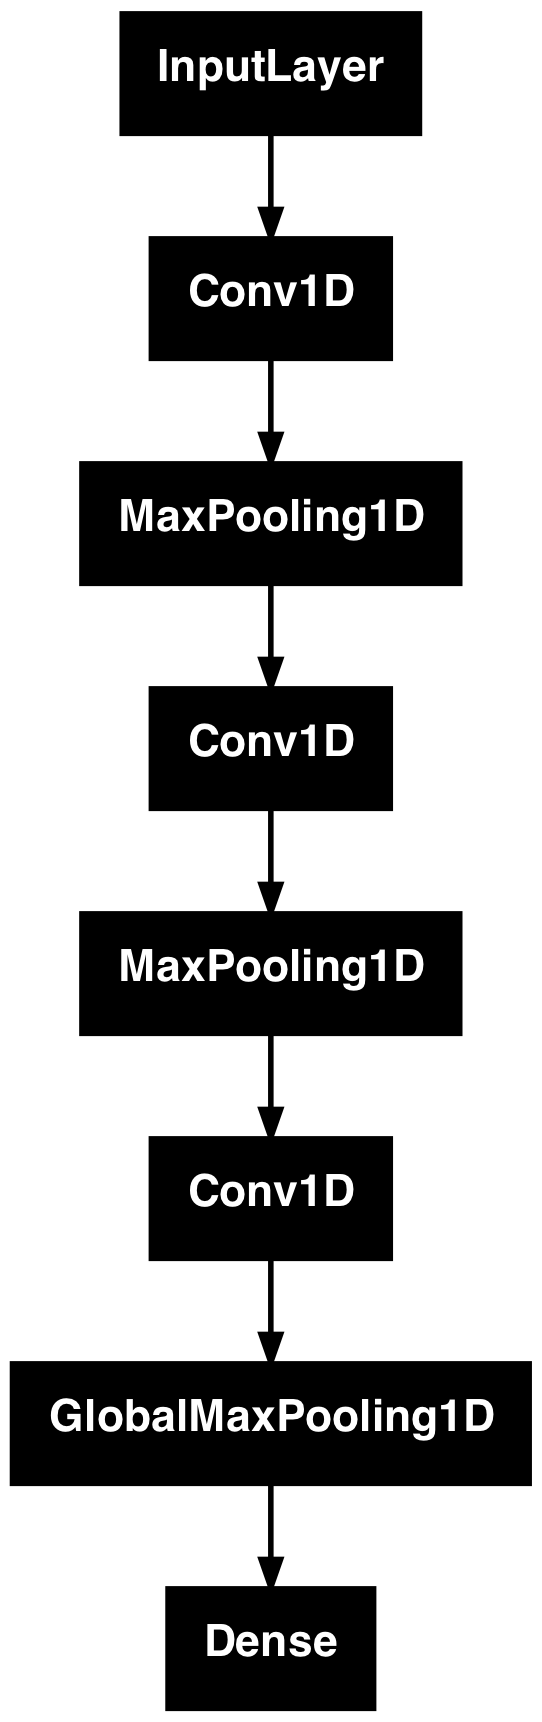

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
# create a checkpoint to save the best model according to validation accuracy 

check_point = ModelCheckpoint('best_model.keras', monitor = 'val_accuracy', save_best_only=True)

# compile the model 

model.compile(loss= SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'],)

In [12]:
# Fit the model 

result = model.fit(X_train, y_train, epochs = 15, callbacks=[check_point], validation_data = (X_test, y_test),)

Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6890 - loss: 0.8210 - val_accuracy: 0.8935 - val_loss: 0.2458
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9429 - loss: 0.1345 - val_accuracy: 0.8972 - val_loss: 0.2241
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9506 - loss: 0.1160 - val_accuracy: 0.9033 - val_loss: 0.2061
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9533 - loss: 0.1053 - val_accuracy: 0.9121 - val_loss: 0.1978
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9568 - loss: 0.0964 - val_accuracy: 0.9196 - val_loss: 0.1840
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9623 - loss: 0.0889 - val_accuracy: 0.9213 - val_loss: 0.1891
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9669 - loss: 0.0823 - val_accuracy: 0.9203 - val_loss: 0.1905
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9699 - loss: 0.0758 - val_accuracy: 

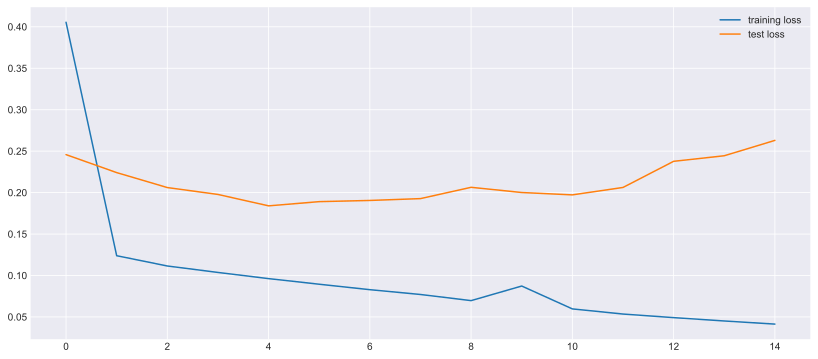

In [13]:
# plot training and test loss per epoch 

fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result.history['loss'], label = 'training loss')
axes.plot(result.history['val_loss'], label = 'test loss')

axes.legend()

axes.grid()

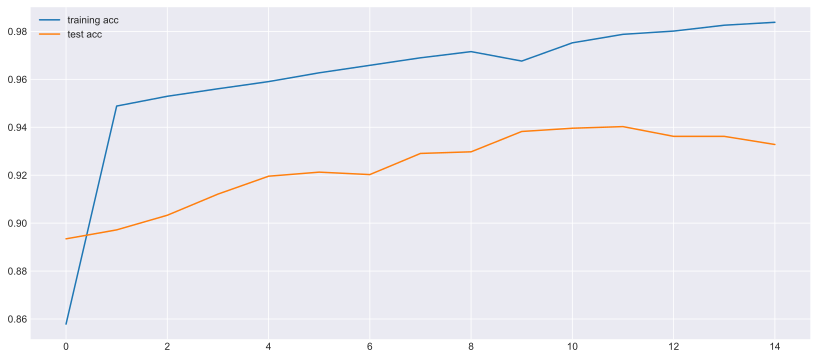

In [14]:
# plot training and test accuracy per epoch 

fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result.history['accuracy'], label = 'training acc')
axes.plot(result.history['val_accuracy'], label = 'test acc')

axes.legend()

axes.grid()

In [15]:
# load the best model 

best_model = tf.keras.models.load_model('best_model.keras')

In [17]:
# make predictions, probs_test gives z_k according to softmax probabilities (also called odds) for each category k
# prob(k) = Exp[z_k]/Sum[Exp[z_k]]] 

probs_test = best_model.predict(X_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [18]:
# evaluate the mean accuracy of the best model which matches with the validation accuracy of the 15th epoch
# we pick the prediction to be the index of the max z_k, higher it is higher the conditional probability 

np.mean(np.argmax(probs_test, axis = 1) == y_test)

0.9402782490668476

### Combined model that also implements the static pre-engineered features
-------

In [19]:
def load_features():

    '''Retruns X_train (N_train x D) and X_test (N_train x D)'''

    # train data 

    df = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header = None, delim_whitespace=True)

    feat_train = df.to_numpy()

    # test data 

    df = pd.read_csv('UCI HAR Dataset/test/X_test.txt', header = None, delim_whitespace=True)

    feat_test = df.to_numpy()

    # scale 
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)

    return feat_train, feat_test

In [20]:
# get training and test sets 

feat_train, feat_test = load_features()

# dimensionality of the features 

D_feat = feat_train.shape[1] 

In [22]:
# Hybrid ANN + CNN model 

# CNN 

i = Input(shape = (T, D))

x = Conv1D(32, 5, activation = 'relu')(i) # since we have a larger time series we chose a larger kernel of 5
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape = (D_feat,))
x2 = Dense(32, activation = 'relu')(i2)

# Put together the 'features' generated by CNN and ANN
x = Concatenate()([x, x2])
x = Dense(K)(x)

hmodel = Model([i,i2],x)

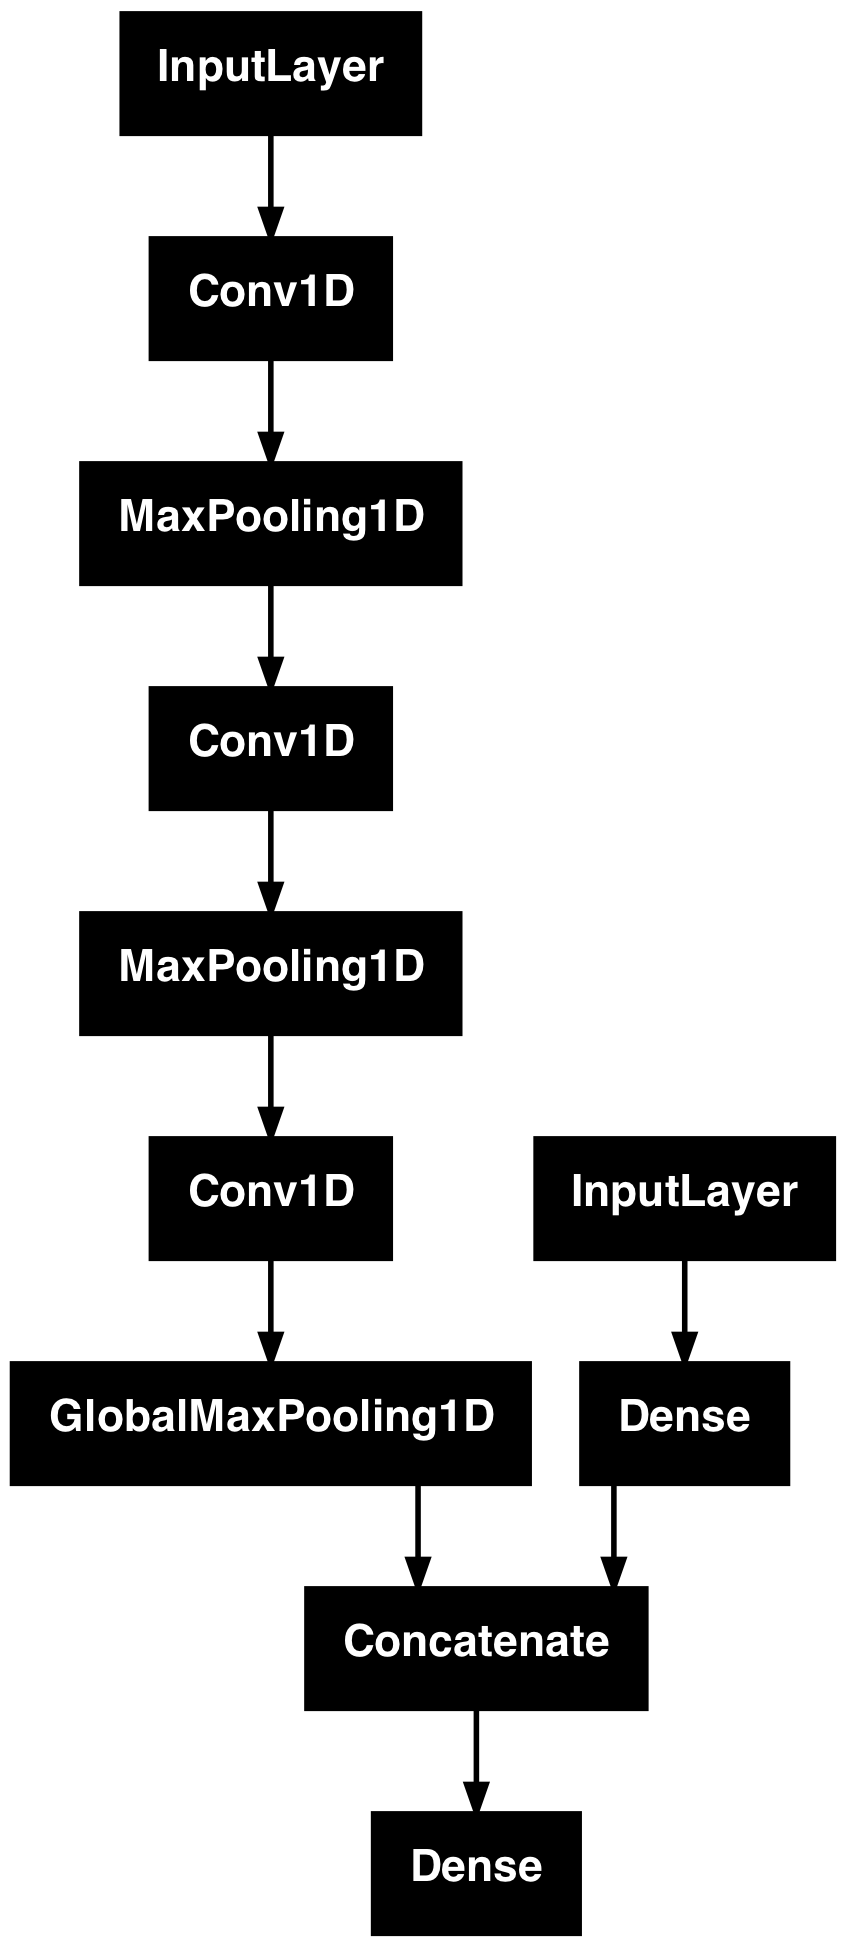

In [23]:
tf.keras.utils.plot_model(hmodel)

In [24]:
hmodel.compile(loss = SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])

# checkpoint 

hcheck_point = ModelCheckpoint('best_hmodel.keras', monitor = 'val_accuracy', save_best_only=True)

In [25]:
# fit 

hres = hmodel.fit([X_train, feat_train] , y_train, epochs = 15, callbacks = [hcheck_point], validation_data=([X_test, feat_test], y_test))

Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8104 - loss: 0.5145 - val_accuracy: 0.9304 - val_loss: 0.1799
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9651 - loss: 0.0868 - val_accuracy: 0.9382 - val_loss: 0.1582
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9765 - loss: 0.0601 - val_accuracy: 0.9447 - val_loss: 0.1501
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9818 - loss: 0.0458 - val_accuracy: 0.9467 - val_loss: 0.1414
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9848 - loss: 0.0382 - val_accuracy: 0.9491 - val_loss: 0.1459
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9888 - loss: 0.0329 - val_accuracy: 0.9491 - val_loss: 0.1537
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9902 - loss: 0.0289 - val_accuracy: 0.9501 - val_loss: 0.1574
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9912 - loss: 0.0282 - val_accuracy: 0

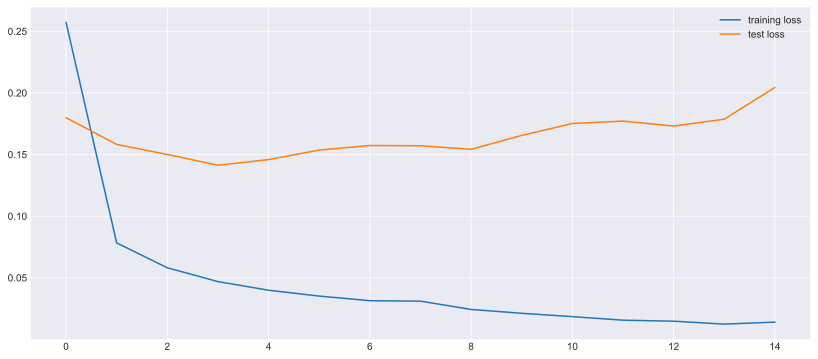

In [26]:
# plot training and test loss per epoch 

fig, axes = plt.subplots(figsize = (14,6))

axes.plot(hres.history['loss'], label = 'training loss')
axes.plot(hres.history['val_loss'], label = 'test loss')

axes.legend()

axes.grid()

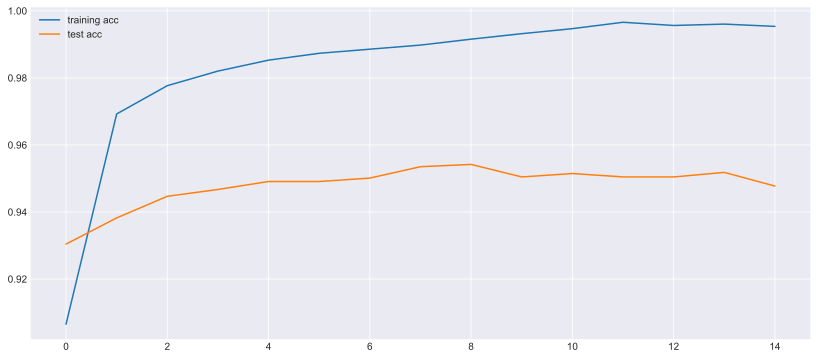

In [27]:
# plot training and test accuracy per epoch 

fig, axes = plt.subplots(figsize = (14,6))

axes.plot(hres.history['accuracy'], label = 'training acc')
axes.plot(hres.history['val_accuracy'], label = 'test acc')

axes.legend()

axes.grid()

In [29]:
# load best model, make predictions and compute the accuracy 

best_model_h = tf.keras.models.load_model('best_hmodel.keras')

probs_test_h = best_model_h.predict([X_test, feat_test])

# mean accuracy of the best model which is slightly better than only time-series approach

np.mean(np.argmax(probs_test_h, axis = 1) == y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9541907024092298